In [1]:
#revisando data
import pandas as pd
import numpy as np
# Ejecuta esto para diagnosticar
print("=== DIAGNÓSTICO DEL PIPELINE ===")

# 1. Revisar data_cleaned
df_cleaned = pd.read_parquet('../data/processed/data_cleaned.parquet')
print(f"data_cleaned: {df_cleaned.shape}")

# 2. Revisar data_processed  
df_processed = pd.read_parquet('../data/processed/data_processed.parquet')
print(f"data_processed: {df_processed.shape}")

# 3. Revisar data_training
df_training = pd.read_parquet('../data/processed/data_training.parquet')
print(f"data_training: {df_training.shape}")

# 4. Revisar datos originales
df_raw = pd.read_parquet('../data/raw/data_sample.parquet')
print(f"data_sample (raw): {df_raw.shape}")

#if 'product_quantity' in df_cleaned.columns:
#    print("\nEn datos CLEANED:")
#    print(f"  - > 0: {(df_cleaned['product_quantity'] > 0).sum()}")
#    print(f"  - == 0: {(df_cleaned['product_quantity'] == 0).sum()}")
#    print(f"  - Distribución:")
#    print(df_cleaned['product_quantity'].value_counts().sort_index().head(10))

=== DIAGNÓSTICO DEL PIPELINE ===
data_cleaned: (36242, 79)
data_processed: (36242, 101)
data_training: (25521, 24)
data_sample (raw): (74457, 77)


Producto: GGOEGFKQ020399


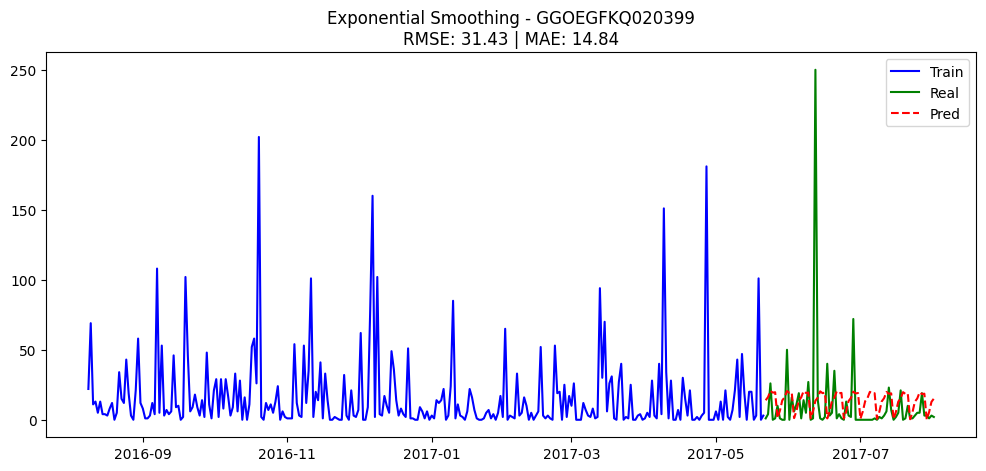

Producto: GGOEGHGC019799


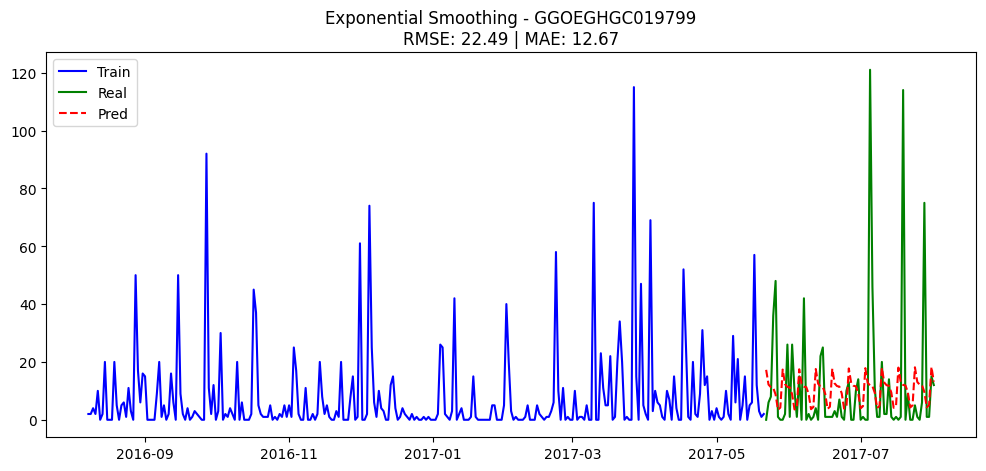

Producto: GGOEGDHC018299


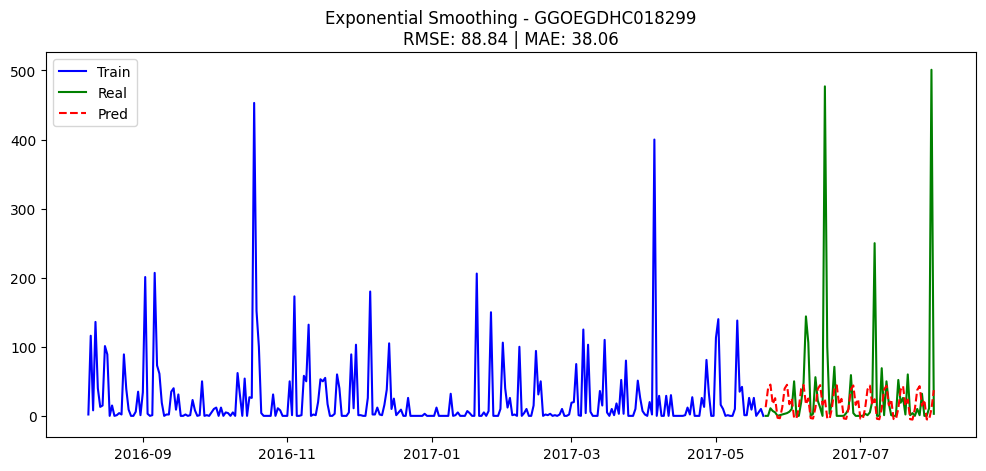

Producto: GGOEGHPB071610


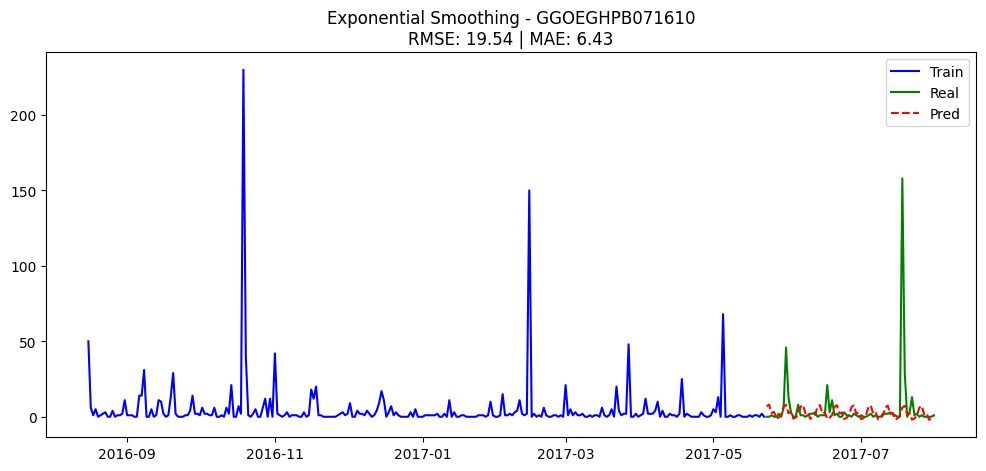

Producto: GGOEYFKQ020699


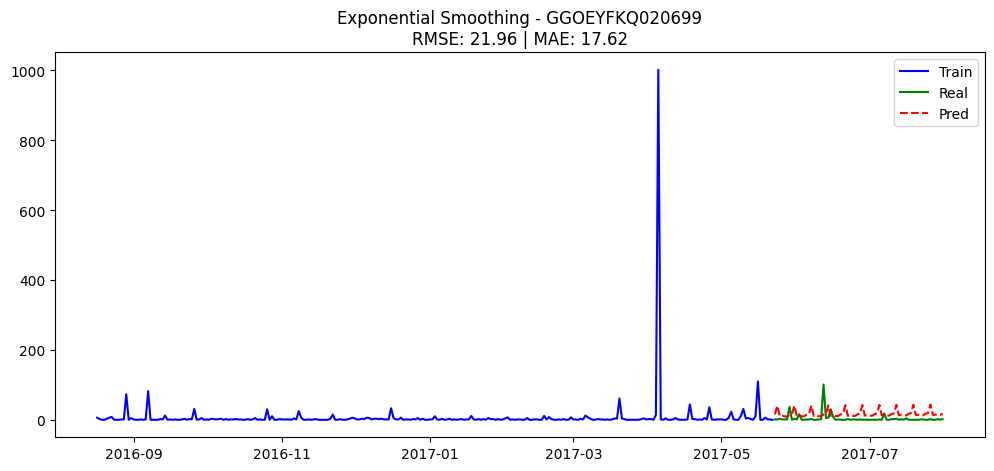

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Agregar a nivel día-producto
df_daily = df_training.groupby(['parsed_date', 'product_sku'])['units_sold'].sum().reset_index()

# Seleccionar productos top
top_products = df_daily['product_sku'].value_counts().head(5).index

for sku in top_products:
    print(f"Producto: {sku}")
    
    # Serie temporal del producto
    product_ts = df_daily[df_daily['product_sku'] == sku]
    ts = product_ts.set_index('parsed_date')['units_sold'].asfreq('D').fillna(0)
    
    if len(ts) < 40:
        continue

    # Train/test split
    split = int(len(ts) * 0.8)
    train, test = ts.iloc[:split], ts.iloc[split:]
    
    if len(test) == 0:
        continue

    # Exponential Smoothing
    model = ExponentialSmoothing(
        train,
        trend="add",
        seasonal="add", 
        seasonal_periods=7
    ).fit()

    pred = model.forecast(len(test))
    
    # Métricas
    rmse = np.sqrt(mean_squared_error(test, pred))
    mae = mean_absolute_error(test, pred)
    
    # Gráfico
    plt.figure(figsize=(12,5))
    plt.plot(train.index, train, label="Train", color="blue")
    plt.plot(test.index, test, label="Real", color="green") 
    plt.plot(test.index, pred, label="Pred", color="red", linestyle="--")
    plt.title(f"Exponential Smoothing - {sku}\nRMSE: {rmse:.2f} | MAE: {mae:.2f}")
    plt.legend()
    plt.show()

    

🚀 ENTRENANDO XGBOOST
📊 Datos finales: 17616 filas
🔧 Productos: 127
📈 Train: 14121, Test: 3495

✅ XGBOOST RESULTS:
RMSE: 4.2867
MAE:  2.9325


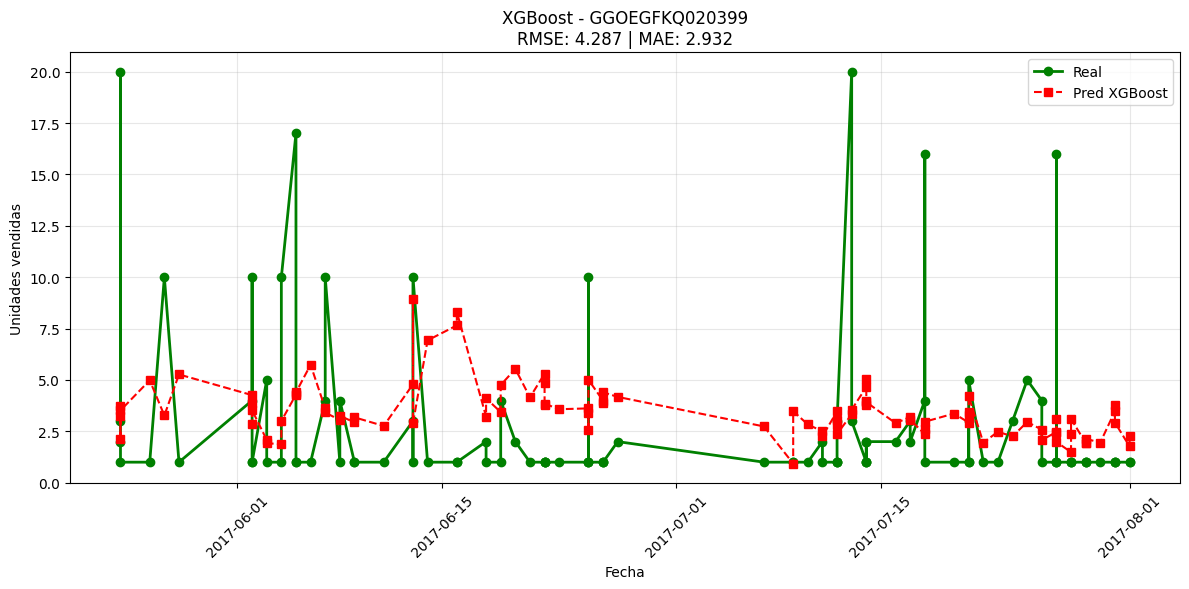

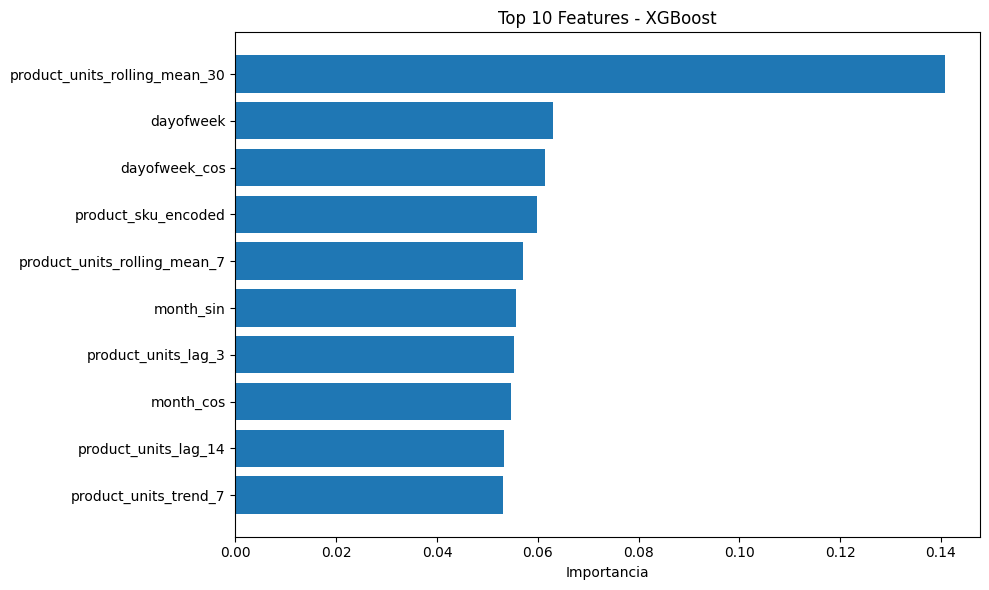


🎯 XGBoost entrenado: RMSE 4.287, MAE 2.932


In [51]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Configuración
plt.style.use('default')

print("🚀 ENTRENANDO XGBOOST")

# 1. PREPARAR DATOS
df_model = df_training.copy()

# Filtrar outliers y productos con suficiente historial
df_filtered = df_model[df_model['units_sold'] <= 20].copy()
product_counts = df_filtered['product_sku'].value_counts()
products_50plus = product_counts[product_counts >= 50].index
df_filtered = df_filtered[df_filtered['product_sku'].isin(products_50plus)]

print(f"📊 Datos finales: {len(df_filtered)} filas")
print(f"🔧 Productos: {len(products_50plus)}")

# 2. DEFINIR FEATURES
available_features = [
    'year', 'month', 'day', 'dayofweek', 'is_weekend', 
    'is_month_start', 'is_month_end', 'month_sin', 'month_cos',
    'dayofweek_sin', 'dayofweek_cos', 'product_units_lag_1',
    'product_units_lag_3', 'product_units_lag_7', 'product_units_lag_14',
    'product_units_rolling_mean_7', 'product_units_rolling_mean_30',
    'product_units_trend_7', 'days_since_last_transaction'
]

available_features = [col for col in available_features if col in df_filtered.columns]

# Codificar producto
le = LabelEncoder()
df_filtered['product_sku_encoded'] = le.fit_transform(df_filtered['product_sku'])
available_features.append('product_sku_encoded')

# 3. DIVIDIR DATOS
df_sorted = df_filtered.sort_values('parsed_date')
split_date = df_sorted['parsed_date'].quantile(0.8)

train_mask = df_sorted['parsed_date'] <= split_date
test_mask = df_sorted['parsed_date'] > split_date

X_train = df_sorted.loc[train_mask, available_features]
X_test = df_sorted.loc[test_mask, available_features]
y_train = df_sorted.loc[train_mask, 'units_sold']
y_test = df_sorted.loc[test_mask, 'units_sold']

print(f"📈 Train: {len(X_train)}, Test: {len(X_test)}")

# 4. MODELO XGBOOST
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# 5. PREDICCIONES Y MÉTRICAS
y_pred_xgb = xgb_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"\n✅ XGBOOST RESULTS:")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"MAE:  {mae_xgb:.4f}")

# 6. GRÁFICO
test_indices = df_sorted[test_mask].index
test_products = df_sorted[test_mask]['product_sku'].value_counts().head(3)

for product_sku, count in test_products.items():
    product_mask = (df_sorted['product_sku'] == product_sku) & test_mask
    if product_mask.sum() > 1:
        product_test_indices = df_sorted[product_mask].index
        mask_positions = [i for i, idx in enumerate(test_indices) if idx in product_test_indices]
        
        y_real_product = y_test.loc[product_test_indices]
        y_pred_product = y_pred_xgb[mask_positions]
        dates_product = df_sorted.loc[product_test_indices, 'parsed_date']
        
        plt.figure(figsize=(12, 6))
        plt.plot(dates_product, y_real_product, label='Real', marker='o', color='green', linewidth=2)
        plt.plot(dates_product, y_pred_product, label='Pred XGBoost', marker='s', color='red', linestyle='--')
        plt.title(f'XGBoost - {product_sku}\nRMSE: {rmse_xgb:.3f} | MAE: {mae_xgb:.3f}')
        plt.xlabel('Fecha')
        plt.ylabel('Unidades vendidas')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        break

# 7. FEATURE IMPORTANCE
feature_imp_xgb = pd.DataFrame({
    'feature': available_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
top_features = feature_imp_xgb.head(10)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importancia')
plt.title('Top 10 Features - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n🎯 XGBoost entrenado: RMSE {rmse_xgb:.3f}, MAE {mae_xgb:.3f}")

🧠 INICIANDO MODELO LSTM CON PYTORCH
📊 Datos para LSTM: 17616 filas
🔢 Secuencias creadas: (17606, 10, 14)
📈 Train: (14084, 10, 14), Test: (3522, 10, 14)
🔄 Arquitectura LSTM PyTorch:
LSTMModel(
  (lstm1): LSTM(14, 64, batch_first=True, dropout=0.2)
  (lstm2): LSTM(64, 32, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


c:\Users\geral\Desktop\UPC\DataScience\pc1_20252_metodologia_data_science\myenv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


🚀 Entrenando LSTM PyTorch...
Época [10/50], Loss: 0.9027, Val Loss: 1.3283
Época [20/50], Loss: 0.8593, Val Loss: 1.2987
Época [30/50], Loss: 0.8271, Val Loss: 1.2677
Época [40/50], Loss: 0.8180, Val Loss: 1.2681
Época [50/50], Loss: 0.8150, Val Loss: 1.2590

✅ LSTM PYTORCH RESULTS:
RMSE: 4.9151
MAE:  3.6026


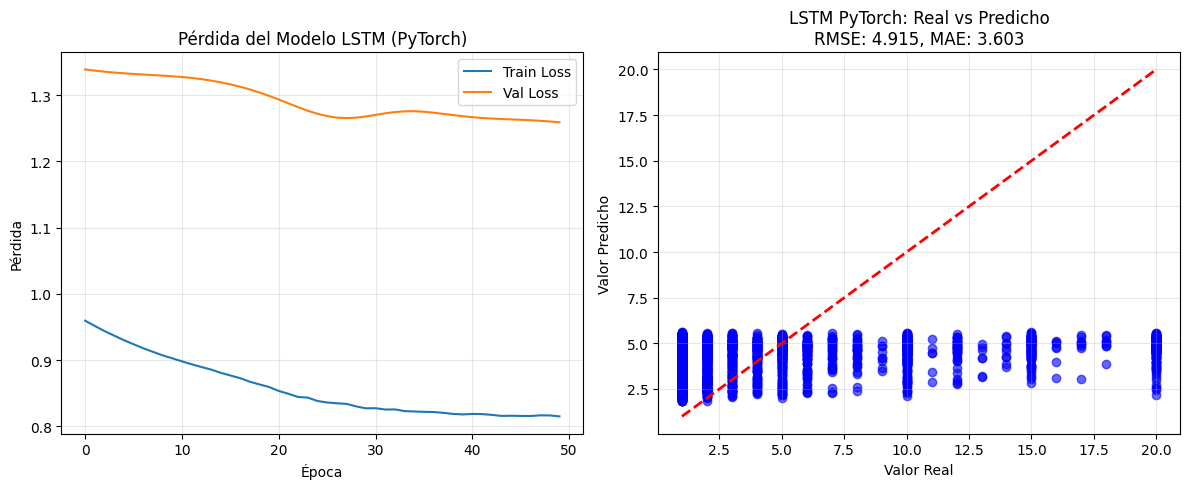


🎯 LSTM PyTorch entrenado: RMSE 4.915, MAE 3.603


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("🧠 INICIANDO MODELO LSTM CON PYTORCH")

# 1. PREPARAR DATOS
df_model = df_training.copy()

# Filtrar datos
df_filtered = df_model[df_model['units_sold'] <= 20].copy()
product_counts = df_filtered['product_sku'].value_counts()
products_50plus = product_counts[product_counts >= 50].index
df_filtered = df_filtered[df_filtered['product_sku'].isin(products_50plus)]

print(f"📊 Datos para LSTM: {len(df_filtered)} filas")

# 2. FEATURES Y ESCALADO
features = [
    'year', 'month', 'day', 'dayofweek', 'is_weekend', 
    'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos',
    'product_units_lag_1', 'product_units_lag_7',
    'product_units_rolling_mean_7', 'product_units_rolling_mean_30'
]

features = [f for f in features if f in df_filtered.columns]

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_filtered['product_sku_encoded'] = le.fit_transform(df_filtered['product_sku'])
features.append('product_sku_encoded')

# Escalar
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(df_filtered[features])
y_scaled = scaler_y.fit_transform(df_filtered[['units_sold']])

# 3. CREAR SECUENCIAS
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(time_steps, len(X)):
        X_seq.append(X[i-time_steps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

time_steps = 10
X_sequences, y_sequences = create_sequences(X_scaled, y_scaled, time_steps)

print(f"🔢 Secuencias creadas: {X_sequences.shape}")

# 4. DIVIDIR DATOS (EXACTAMENTE IGUAL)
split_idx = int(0.8 * len(X_sequences))
X_train_seq = X_sequences[:split_idx]
X_test_seq = X_sequences[split_idx:]
y_train_seq = y_sequences[:split_idx]
y_test_seq = y_sequences[split_idx:]

print(f"📈 Train: {X_train_seq.shape}, Test: {X_test_seq.shape}")

# 5. MODELO LSTM EN PYTORCH
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True, dropout=0.2)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True, dropout=0.2)
        self.fc1 = nn.Linear(hidden_size2, 16)
        self.fc2 = nn.Linear(16, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # LSTM capa 1
        lstm1_out, _ = self.lstm1(x)
        lstm1_out = self.dropout(lstm1_out)
        
        # LSTM capa 2
        lstm2_out, _ = self.lstm2(lstm1_out)
        lstm2_out = self.dropout(lstm2_out)
        
        # Solo la última salida de la secuencia
        last_output = lstm2_out[:, -1, :]
        
        # Capas densas
        dense_out = self.relu(self.fc1(last_output))
        output = self.fc2(dense_out)
        
        return output

# Crear modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_size=X_train_seq.shape[2]).to(device)
print("🔄 Arquitectura LSTM PyTorch:")
print(model)

# 6. ENTRENAR
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convertir datos a tensores PyTorch
X_train_tensor = torch.FloatTensor(X_train_seq).to(device)
y_train_tensor = torch.FloatTensor(y_train_seq).to(device)
X_test_tensor = torch.FloatTensor(X_test_seq).to(device)
y_test_tensor = torch.FloatTensor(y_test_seq).to(device)

print("🚀 Entrenando LSTM PyTorch...")

train_losses = []
val_losses = []

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Validación
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
    
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Época [{epoch+1}/50], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# 7. PREDICCIONES
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).cpu().numpy()

y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled).flatten()
y_true_lstm = scaler_y.inverse_transform(y_test_seq).flatten()

# 8. MÉTRICAS
rmse_lstm = np.sqrt(mean_squared_error(y_true_lstm, y_pred_lstm))
mae_lstm = mean_absolute_error(y_true_lstm, y_pred_lstm)

print(f"\n✅ LSTM PYTORCH RESULTS:")
print(f"RMSE: {rmse_lstm:.4f}")
print(f"MAE:  {mae_lstm:.4f}")

# 9. GRÁFICOS
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Pérdida del Modelo LSTM (PyTorch)')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_true_lstm, y_pred_lstm, alpha=0.6, color='blue')
plt.plot([y_true_lstm.min(), y_true_lstm.max()], 
         [y_true_lstm.min(), y_true_lstm.max()], 'r--', lw=2)
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.title(f'LSTM PyTorch: Real vs Predicho\nRMSE: {rmse_lstm:.3f}, MAE: {mae_lstm:.3f}')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🎯 LSTM PyTorch entrenado: RMSE {rmse_lstm:.3f}, MAE {mae_lstm:.3f}")

In [ ]:
#XGBoost (Mejor rendimiento: RMSE 4.287) mas robusto para datos granulares
#LSTM PyTorch (Deep Learning: RMSE 4.915) ligeramente inferior a XGBoost
#Exponential Smoothing (Peor) no generaliza entre productos